# Library

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import random 
import numpy as np
import pandas as pd
from torchinfo import summary
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
import wandb
import os
from dotenv import load_dotenv
from torchvision.datasets import DatasetFolder
from PIL import Image
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split, Subset

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from simdinov2.models.return_models import get_dino_finetuned_downloaded

/media/new_volumn/SimDINO/simdinov2/layers/swiglu_ffn.py:43: UserWarning: Using xFormers (SwiGLU)
  warnings.warn("Using xFormers (SwiGLU)")
/media/new_volumn/SimDINO/simdinov2/layers/attention.py:27: UserWarning: Using xFormers (Attention)
  warnings.warn("Using xFormers (Attention)")
/media/new_volumn/SimDINO/simdinov2/layers/attention.py:38: UserWarning: Using SDPA Attention
  warnings.warn("Using SDPA Attention")
/media/new_volumn/SimDINO/simdinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


# Loading Data

In [2]:
def split(full_dataset, val_percent, test_percent, random_seed=42):
    amount = len(full_dataset)

    test_amount = (
        int(amount * test_percent)
        if test_percent is not None else 0)
    val_amount = (
        int(amount * val_percent)
        if val_percent is not None else 0)
    train_amount = amount - test_amount - val_amount

    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        (train_amount, val_amount, test_amount),
        generator=(
            torch.Generator().manual_seed(random_seed)
            if random_seed
            else None))
    
    return train_dataset, val_dataset, test_dataset

In [3]:
dir = "images_india/"
full_dataset = datasets.ImageFolder(dir, transform=None, target_transform=None)

class_to_idx = full_dataset.class_to_idx  # Dictionary mapping class names to indices
# Reverse the dictionary to get index-to-class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_dataset, val_dataset, test_dataset = split(full_dataset, 0.15, 0.15, random_seed=42)

# Extract labels from the dataset
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]
test_labels = [label for _, label in test_dataset]

In [4]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [21]:
train_labels[0:10], idx_to_class

(array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0]), {0: '1121', 1: '1509'})

In [5]:
intensity_ranges = {
        "brightness": np.linspace(0.9, 1.1, 5),  # Range should be >0
        "contrast": np.linspace(0.9, 1.1, 5),
        "saturation": np.linspace(0.9, 1.1, 5),  # Ensure positive values
        "hue": np.linspace(-0.05, 0.05, 5)  # Hue range should be (-0.5, 0.5)
        }

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    # transforms.RandomApply(
    # [transforms.ColorJitter(brightness=(intensity_ranges["brightness"].min(), intensity_ranges["brightness"].max()),
    #                         contrast=(intensity_ranges["contrast"].min(), intensity_ranges["contrast"].max()),
    #                         saturation=(intensity_ranges["saturation"].min(), intensity_ranges["saturation"].max()),
    #                         hue=(intensity_ranges["hue"].min(), intensity_ranges["hue"].max()))],
    #                         p=0.8,),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

In [7]:
# # Wrap subsets in `Subset` and apply transformations
# class TransformSubset(Subset):
#     def __init__(self, subset, transform):
#         self.subset = subset
#         self.transform = transform

#     def __getitem__(self, index):
#         image, label = self.subset[index]
#         return self.transform(image), label  # Apply transform

#     def __len__(self):
#         return len(self.subset)

# train_dataset = TransformSubset(train_dataset, transform)
# val_dataset = TransformSubset(val_dataset, transform)
# test_dataset = TransformSubset(test_dataset, transform)

In [6]:
model_path = "patch16/eval/training_199999/teacher_checkpoint.pth" # full training
transformer = get_dino_finetuned_downloaded(model_path=model_path, modelname="dinov2_vitb14_reg")
transformer.to("cuda")

Using cache found in /home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/easyrice/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Pretrained weights found at patch16/eval/training_199999/teacher_checkpoint.pth and loaded with msg: <All keys matched successfully>


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [7]:
def get_embeddings(data, model):
    embeddings = []

    for image, _ in tqdm(data, desc="Extracting embeddings"):
        model.eval()
        with torch.no_grad():
            # image = image[0]
            # image = Image.fromarray(image) # Load image
            image = transform(image)  # Apply normalization
            image = image.unsqueeze(0) # Add batch dimension
            image = transformer(image.to("cuda"))
            embeddings.append(image.cpu().numpy())

    return np.array(embeddings)


In [8]:
train_embeddings = get_embeddings(train_dataset, transformer)
valid_embeddings = get_embeddings(val_dataset, transformer)
test_embeddings = get_embeddings(test_dataset, transformer)


Extracting embeddings: 100%|██████████| 2993/2993 [00:20<00:00, 148.39it/s]


In [ ]:
os.makedirs("embeddings/17March", exist_ok=True)

In [ ]:
np.save("embeddings/17March/train_embeddingsIndianRice.npy", train_embeddings)
np.save("embeddings/17March/valid_embeddingsIndianRice.npy", valid_embeddings)
np.save("embeddings/17March/test_embeddingsIndianRice.npy", test_embeddings)

In [72]:
train_embeddings = np.load("embeddings/17March/train_embeddingsIndianRice.npy")
valid_embeddings = np.load("embeddings/17March/valid_embeddingsIndianRice.npy")  
test_embeddings = np.load("embeddings/17March/test_embeddingsIndianRice.npy")

In [9]:
train_embeddings = torch.from_numpy(train_embeddings).float()
valid_embeddings = torch.from_numpy(valid_embeddings).float()
test_embeddings = torch.from_numpy(test_embeddings).float()

In [10]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data  # NumPy array of images embeddings
        self.y_data = y_data  # NumPy array of labels
        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):

        embeddings = self.x_data[idx]        
        label = self.y_data[idx]  # Get corresponding label

        return embeddings, torch.tensor(label, dtype=torch.float).view(-1)

In [11]:
train_dataset = CustomDataset(train_embeddings, train_labels, None)
valid_dataset = CustomDataset(valid_embeddings, val_labels, None)
test_dataset = CustomDataset(test_embeddings, test_labels, None)

In [13]:
train_dataset[0][1].shape

torch.Size([1])

In [12]:
train_embeddings.shape, train_labels.shape

(torch.Size([13969, 1, 768]), (13969,))

In [13]:
train_class_counts = Counter(train_labels)
train_class_counts, idx_to_class

(Counter({np.int64(1): 7215, np.int64(0): 6754}), {0: '1121', 1: '1509'})

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [15]:
for x, y in train_loader:
    print(x.shape, y.shape)
    # print(y)
    break

torch.Size([64, 1, 768]) torch.Size([64, 1])


In [16]:
for x, y in val_loader:
    print(x.shape, y.shape)
    # print(y)
    break

torch.Size([64, 1, 768]) torch.Size([64, 1])


# Transformer Model Initializing

# Classifier

In [17]:
class TransformerClassifier(pl.LightningModule):
    def __init__(self, num_classes=3, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes), # logits
            nn.Sigmoid() # probability
        )
        
        self.criterion = nn.BCELoss() 
        self.learning_rate = learning_rate

    def forward(self, x):
        x = x.squeeze(1) # squeeze the second dimension of the embeddings
        logits = self.classifier(x)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        threshold = 0.5  # You can change this threshold if needed
        preds = (logits > threshold).float()  
    
        # Calculate accuracy: Number of correct predictions / Total number of predictions
        correct = (preds == y).sum().item()
        accuracy = correct / y.size(0)  # Divide by batch size to get accuracy

        self.log("train_loss", loss, prog_bar=True)
        wandb.log({"train_loss": loss, "train_acc": accuracy})
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        threshold = 0.5  
        preds = (logits > threshold).float()  

        # Calculate accuracy: Number of correct predictions / Total number of predictions
        correct = (preds == y).sum().item()
        accuracy = correct / y.size(0)  # Divide by batch size to get accuracy

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        wandb.log({"val_loss": loss, "val_acc": accuracy})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)

# Model training

In [18]:
# Initialize model
classifier_model = TransformerClassifier(num_classes=1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',         # Monitor validation accuracy
    dirpath='checkpoints/18March/',    # Directory to save the checkpoints
    filename='best_model18MarchIndianRice',     # Filename for the best model
    save_top_k=1,              # Save only the best model
    mode='max',                # We want the maximum validation accuracy
)
# Trainer setup
trainer = pl.Trainer(max_epochs=100, 
                     accelerator="gpu" if torch.cuda.is_available() else "mps",
                     callbacks=[checkpoint_callback])

load_dotenv()
wandb.login(key=os.getenv("WANDB_API_KEY"))
wandb.init(project="SIMDINOv2Classifier", name="train6 (Indian Rice, Transformer not finetuned yet)")
#Training
trainer.fit(classifier_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/easyrice/.netrc
wandb: Currently logged in as: sanchai-mol (easyrice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-18 13:12:12.319513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742278332.331747  464630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742278332.335493  464630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 13:12:12.348569: I tensorflow/core/platform/cpu_feature_guard.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/easyrice/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/easyrice/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [19]:
!wandb login --revoke

Usage: wandb login [OPTIONS] [KEY]...
Try 'wandb login --help' for help.

Error: No such option: --revoke


# Confusion Matrix

In [24]:
def predict_and_transform(model, val_loader):
    
    class_indices = {"1121": 0, "1509": 1}
    predictions = []
    

    # Disable gradient computation for inference
    model.to("cuda")
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x_batch = batch[0].to("cuda")
            x_batch = x_batch.squeeze(1)
            logits = model(x_batch)
            threshold = 0.5  
            preds = (logits > threshold).float()  
            predictions.extend(preds.cpu().numpy())  # Move back to CPU and store the predictions

    predicted_classes = np.array(predictions)

    
    return predicted_classes

In [25]:
classifier_model = TransformerClassifier.load_from_checkpoint("checkpoints/18March/best_model18MarchIndianRice.ckpt")
predicted_classes = predict_and_transform(classifier_model, test_loader)

del classifier_model # Delete the model to free up memory

In [27]:
def plot_confusion_matrix_percentage(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentage
    cm_percentage = np.nan_to_num(cm_percentage)  # Handle division by zero
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

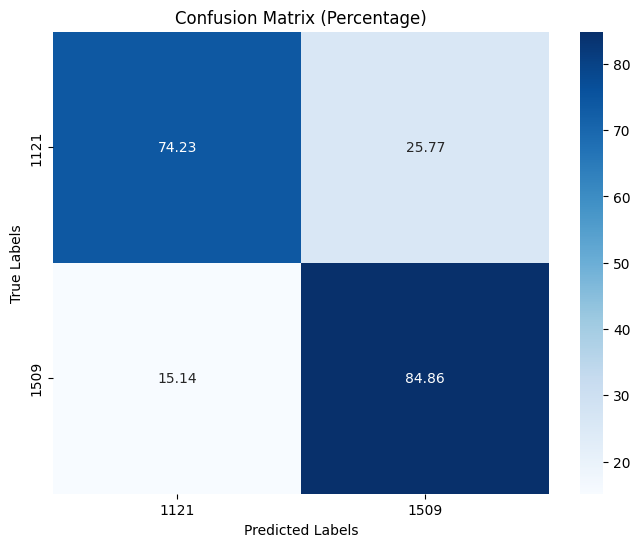

In [28]:
plot_confusion_matrix_percentage(test_labels, predicted_classes, ['1121', '1509'])